In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from langdetect import detect

import warnings; warnings.simplefilter('ignore')

# Categorizing Videos By Text

In [2]:
# Video Related Features
dfData = pd.read_csv('../data/All_data_cbs.csv')

In [3]:
dfData = dfData[dfData['channelVideoCount']<2000]
dfData = dfData[dfData['subscriberCount'] >0]


In [4]:
dfData.head()

,Unnamed: 0,Unnamed: 0.1,rowHash,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,...,subscriberCount,channelVideoCount,channelViewCount,nextHash,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,Title-clickbait
0,0,0,0,Scp3JH3eVLw,Depeche Mode It's No Good,DANCA MUITO.,0,0,18,0,...,10296,37,8251061,1.0,0.0,2.0,14.0,2012-03-28T18:01:31.000Z,3911.0,0.660503
1,1,1,1,wLqmkz6u8G4,the best of Jay cutler Dorian Yates,Jay cutler e Dorian Yates,14,2,3911,0,...,10296,37,8251061,2.0,5.0,2.0,8.0,2010-08-23T16:12:50.000Z,3853.0,0.782542
2,2,2,2,nKMsh79uOcM,Iron Man Andy photos NO PAIN NO GAIN,Iron Man Andy muscle NO PAIN NO GAIN,8,2,3853,0,...,10296,37,8251061,3.0,0.0,2.0,3.0,2010-05-17T10:15:48.000Z,1392.0,0.974470
3,3,3,4,E--7XtuuqAg,Mooring Anchor Carry 120kg at Papar Strongestm...,Only manage 11 meters,0,0,56,0,...,288,79,123988,5.0,0.0,0.0,0.0,2016-10-10T15:01:02.000Z,74.0,0.323020
4,4,4,5,fdsppIOelPw,Tire Flip 450kg at Papar Strongestman 2016,450kg x 5 flips,0,0,74,0,...,288,79,123988,6.0,0.0,0.0,0.0,2016-10-10T14:59:15.000Z,46.0,0.260023


# Feature Creation using Title and Description Text

## Looking at Categorical Workouts

In [5]:
# Conver to lower case 
dfData['Title'] = dfData['Title'].str.lower()


# How To
dfData['HowTo'] = (dfData['Title'].str.contains('how'))

# Motivational
dfData['Motivation'] = (dfData['Title'].str.contains('motivation'))


# Transformation
dfData['Transform'] = (dfData['Title'].str.contains('transform'))

# Abs Workout
dfData['Abs Video'] = (dfData['Title'].str.contains('abs')  | 
                       dfData['Title'].str.contains('six') | 
                       dfData['Title'].str.contains(' 6') | 
                       dfData['Title'].str.contains('abdomen'))
        
# Chest Workout
dfData['Chest Video'] = (dfData['Title'].str.contains('chest')  |
                         dfData['Title'].str.contains('pushup') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('push up') |
                         dfData['Title'].str.contains('dumbell press'))

# Back Workouts 
dfData['Back Video'] = (dfData['Title'].str.contains('back') | 
                        dfData['Title'].str.contains('pull up') | 
                        dfData['Title'].str.contains('chin up')  | 
                        dfData['Title'].str.contains('deadlift'))

# Leg Workouts
dfData['Legs Video'] = (dfData['Title'].str.contains('leg') | 
                        dfData['Title'].str.contains('squat') | 
                        dfData['Title'].str.contains('butt') | 
                        dfData['Title'].str.contains('quad') | 
                        dfData['Title'].str.contains('calve') )

# Arm Workout
dfData['Arm Video'] = (dfData['Title'].str.contains('shoulder') | 
                       dfData['Title'].str.contains('arm') | 
                       dfData['Title'].str.contains('bicep')  |
                       dfData['Title'].str.contains('tricep') | 
                       dfData['Title'].str.contains('delt'))



In [6]:
dfData.loc[dfData['Abs Video'] == True , 'Category'] = 'Abs'
dfData.loc[dfData['Chest Video'] == True , 'Category'] = 'Chest'
dfData.loc[dfData['Back Video'] == True, 'Category'] = 'Back'
dfData.loc[dfData['Legs Video'] == True, 'Category'] = 'Legs'
dfData.loc[dfData['Arm Video'] == True, 'Category'] = 'Arms'
dfData.loc[dfData['Motivation'] == True, 'Category'] = 'Motivation'
dfData.loc[dfData['HowTo'] == True, 'Category'] = 'HowTo'
dfData.loc[dfData['Motivation'] == True, 'Category'] = 'Motivation'
dfData.loc[dfData['Transform'] == True, 'Category'] = 'Transform'

In [7]:
#dfData = dfData.drop(['Abs Video', 'Chest Video','Back Video','Legs Video', 'Arm Video'], axis =1 )
dfData[dfData['Category'].isnull()].shape[0]

67831

In [8]:
dfData = dfData[dfData['Category'].notnull()]

In [9]:
absVid = dfData[dfData['Category'] == 'Abs']
chestVid = dfData[dfData['Category'] == 'Chest']
backVid = dfData[dfData['Category'] == 'Back']
legsVid = dfData[dfData['Category'] == 'Legs']
armsVid = dfData[dfData['Category'] == 'Arms']

print "Number of Abs Related Videos: " + str(absVid.shape[0])
print "Number of Chest Related Videos: " + str(chestVid.shape[0])
print "Number of Back Related Videos: " + str(backVid.shape[0])
print "Number of Leg Related Videos: " + str(legsVid.shape[0])
print "Number of Arm Related Videos: " + str(armsVid.shape[0])

Number of Abs Related Videos: 1871
Number of Chest Related Videos: 2675
Number of Back Related Videos: 3284
Number of Leg Related Videos: 4356
Number of Arm Related Videos: 4496


## Maybe just Body Part Videos

In [10]:
#dfData = dfData[dfData['Category'].notnull()]
#dfData.shape[0]

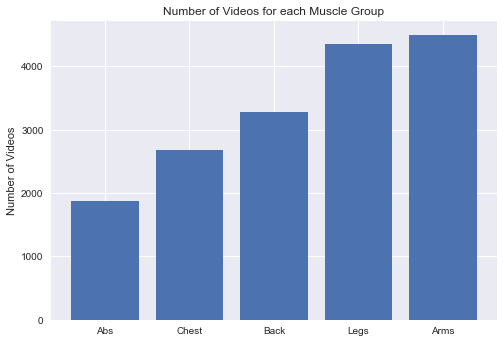

In [11]:
yCols = ['Abs', 'Chest', 'Back', 'Legs', 'Arms']
xCols = [absVid.shape[0], chestVid.shape[0], backVid.shape[0], legsVid.shape[0], armsVid.shape[0]]
y = np.arange(len(yCols))
plt.bar(y, xCols,align = 'center')
plt.xticks(y,yCols)
plt.ylabel("Number of Videos")
plt.title("Number of Videos for each Muscle Group")

## Observation
Legs/Abs/Arms being the most since they target both a guy/girl audience

## Understanding View Distribution

Category
Motivation    129344.721637
Transform      40973.867890
Chest          28579.705421
HowTo          24131.251253
Abs            20405.567076
Arms           19198.255116
Legs           16286.413453
Back           16042.858100
Name: ViewCount, dtype: float64


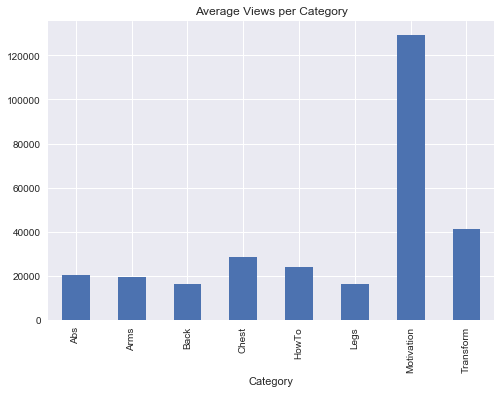

In [12]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').ViewCount.mean().sort_values(ascending = False))
plt.title("Average Views per Category")
plt.show()

Category
Motivation    707.408555
Transform     396.515596
HowTo         381.314844
Abs           273.920898
Chest         262.340935
Back          237.606882
Legs          213.938017
Arms          188.471530
Name: LikeCount, dtype: float64


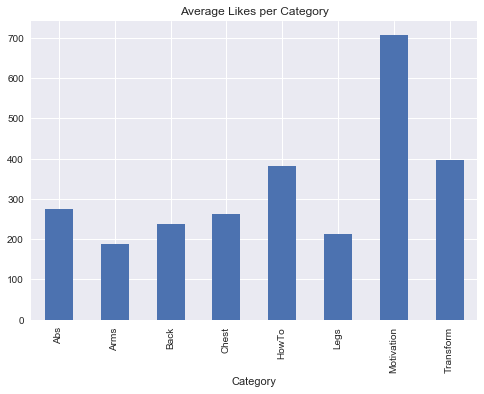

In [13]:
dfData.groupby('Category').LikeCount.mean().plot(kind="bar")
print(dfData.groupby('Category').LikeCount.mean().sort_values(ascending = False))
plt.title("Average Likes per Category")
plt.show()

Category
HowTo         66.276482
Transform     54.906422
Motivation    51.208308
Chest         36.995140
Back          30.626979
Legs          27.453168
Abs           24.502405
Arms          24.423932
Name: CommentCount, dtype: float64


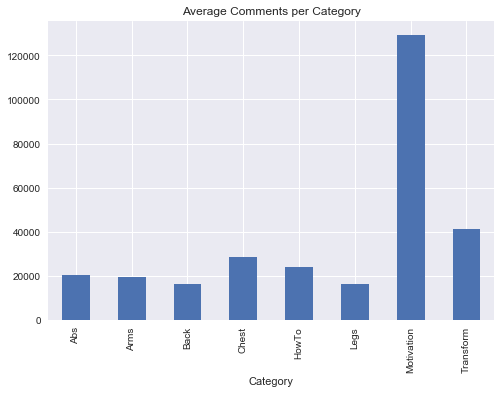

In [14]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').CommentCount.mean().sort_values(ascending = False))
plt.title("Average Comments per Category")
plt.show()

## Observation

Despite Legs having more videos than chest/abs, it has the least amount of views and likes.
The most liked videos are chest and abs

### Categorizing by "Sponsored" and "Description Box" 

In [15]:
# Abs Workout
dfData['isSponsored'] = (dfData['Description'].str.contains('sponsored')  | 
                       dfData['Description'].str.contains('provided by'))

dfData['hasDiscount'] = (dfData['Description'].str.contains("discount") |
                        dfData['Description'].str.contains("code"))

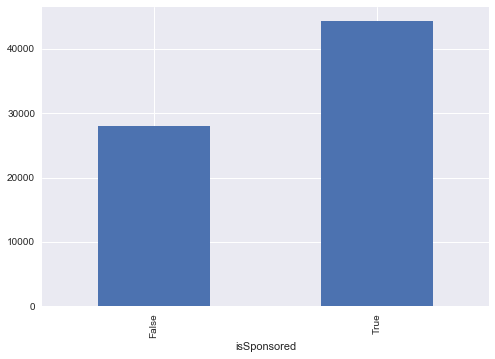

In [16]:
dfData.groupby('isSponsored').ViewCount.mean().plot(kind="bar")

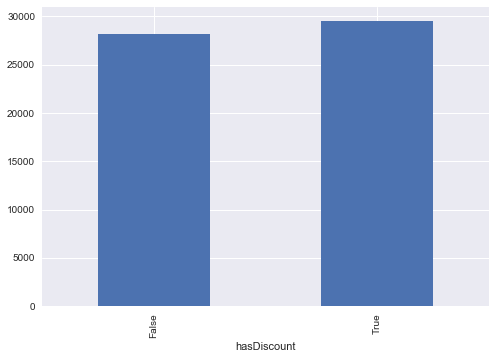

In [17]:
dfData.groupby('hasDiscount').ViewCount.mean().plot(kind="bar")

In [18]:
dfData['LikeDislikeRatio'] = dfData['LikeCount']/(dfData['LikeCount'] + dfData['DislikeCount'])

In [19]:
# Motivation
# Transformation
# Keywords: Ripped/Extreme/sexy/fat/intense
# BodyBuilding
# Tutorial/How To

In [20]:
dfData.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'rowHash', u'Id', u'Title',
       u'Description', u'LikeCount', u'DislikeCount', u'ViewCount',
       u'FavoriteCount', u'CommentCount', u'PublishedAt', u'Channel Id',
       u'Channel Title', u'Lang', u'publishedAt', u'subscriberCount',
       u'channelVideoCount', u'channelViewCount', u'nextHash',
       u'PrevCommentCount', u'PrevDislikeCount', u'PrevLikeCount',
       u'PrevPublishedAt', u'PrevViewCount', u'Title-clickbait', u'HowTo',
       u'Motivation', u'Transform', u'Abs Video', u'Chest Video',
       u'Back Video', u'Legs Video', u'Arm Video', u'Category', u'isSponsored',
       u'hasDiscount', u'LikeDislikeRatio'],
      dtype='object')

In [21]:
dfData.shape

(24627, 38)

In [68]:
def feature_engineer(dfData):
    dfData =dfData.drop(['Category'],axis =1)
    dfData['is_english'] = dfData['Lang'].apply(lambda x: 1 if x=='en' else 0)
    dfData = dfData.drop('Lang', axis=1)
    
    dfData['is_Abs'] = dfData['Abs Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Chest'] = dfData['Chest Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Back'] = dfData['Back Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Legs'] = dfData['Legs Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Arms'] = dfData['Arm Video'].apply(lambda x: 1 if x==True else 0)
    dfData['isSponsored'] = dfData['isSponsored'].apply(lambda x: 1 if x==True else 0)
    dfData['Motivation'] = dfData['Motivation'].apply(lambda x: 1 if x==True else 0)
    dfData['HowTo'] = dfData['HowTo'].apply(lambda x: 1 if x==True else 0)
    dfData['PublishedYear'] = dfData['PublishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log1p(dfData['channelViewCount'])

    dfData = dfData.drop(['Title','Description','PublishedAt','publishedAt','Channel Id','Channel Title','Abs Video','Chest Video','Back Video',
                          'Legs Video','Arm Video','PrevPublishedAt','Id','Unnamed: 0','rowHash','FavoriteCount','nextHash','hasDiscount','PublishedYear'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

def drop_engineered_features(dfData):
    dfData = dfData.drop(['nsfw_score','Title-Clickbait'],axis = 1)
    return dfData


In [69]:
df = feature_engineer(dfData).drop('LikeDislikeRatio',axis =1)

In [70]:
df.columns

Index([u'Unnamed: 0.1', u'LikeCount', u'DislikeCount', u'ViewCount',
       u'CommentCount', u'subscriberCount', u'channelVideoCount',
       u'channelViewCount', u'PrevCommentCount', u'PrevDislikeCount',
       u'PrevLikeCount', u'PrevViewCount', u'Title-clickbait', u'HowTo',
       u'Motivation', u'Transform', u'isSponsored', u'is_english', u'is_Abs',
       u'is_Chest', u'is_Back', u'is_Legs', u'is_Arms', u'ChannelAge'],
      dtype='object')

In [71]:
X, y = df.drop('ViewCount',axis = 1) , np.log1p(df['ViewCount'])

In [72]:
def checkForNull(X,y):
    X = X.as_matrix().astype(float)
    print "Check For Null Values"
    for i in range(0,len(df.columns)-1):
        print np.any(np.isnan(X[:,i]))
    print "Check for Pred:"
    y = y.as_matrix().astype(float)
    print np.any(np.isnan(y))
checkForNull(X,y)

Check For Null Values
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Check for Pred:
False


In [73]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor


In [74]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)



In [75]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.8864740031379702

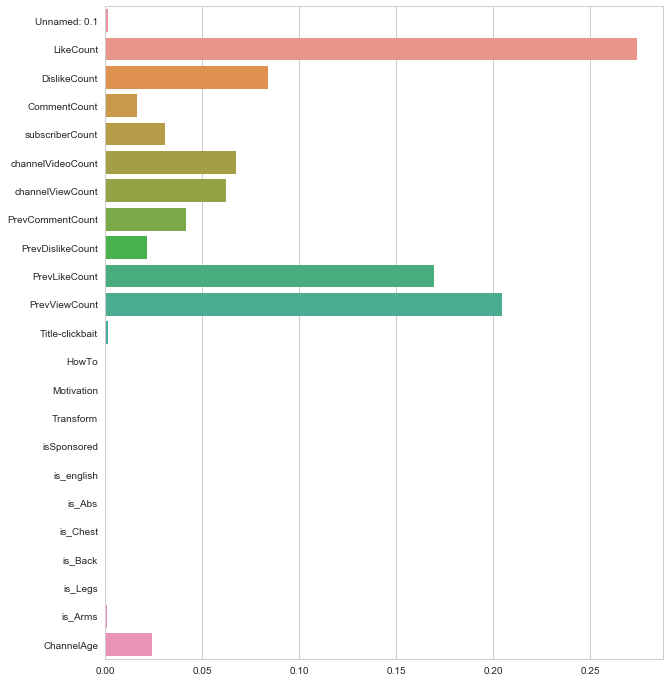

In [76]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

In [77]:
df = drop_obvious_features(feature_engineer(dfData)).drop('LikeDislikeRatio',axis = 1)
print df.columns
X, y = df.drop(['ViewCount'],axis=1), np.log1p(df['ViewCount'])
checkForNull(X,y)
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)



reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)



Index([u'Unnamed: 0.1', u'ViewCount', u'subscriberCount', u'channelVideoCount',
       u'channelViewCount', u'PrevCommentCount', u'PrevDislikeCount',
       u'PrevLikeCount', u'PrevViewCount', u'Title-clickbait', u'HowTo',
       u'Motivation', u'Transform', u'isSponsored', u'is_english', u'is_Abs',
       u'is_Chest', u'is_Back', u'is_Legs', u'is_Arms', u'ChannelAge'],
      dtype='object')
Check For Null Values
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Check for Pred:
False


0.68888161223944722

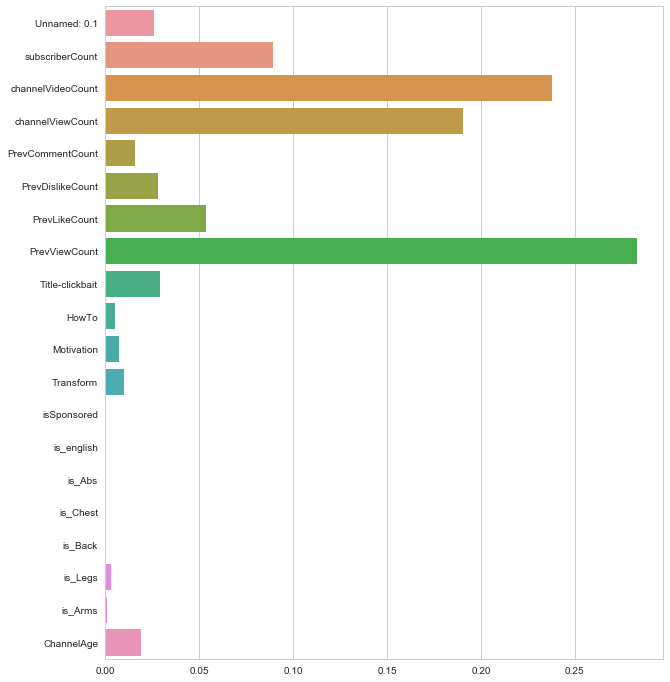

In [78]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

In [79]:
reg = XGBRegressor(n_estimators = 1000)
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)

reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.69569355138516698

In [80]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
reg = linear_model.LinearRegression()
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.41564354645297397

In [81]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)

reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.65239706717377